In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests

%matplotlib inline

## Задача 1

## Задача 2

**Решение:**

Пусть верны гипотезы с индексами $i_1,\dots, i_k$. Переупорядочим гипотезы согласно вариационному ряду p-значений. После этого пусть верные гипотезы имеют индексы $j_1 < \dots < j_k$.

Т.к. если мы не отвергаем гипотезу $j_1$, то по алгоритму процедуры Холма мы не отвергем все остальные, то 

$$P(V > 0) = P(p_{j_1} < \alpha_{j_1}) = * $$


Распишем более подробно эту вероятноть, учитывая то, что $j_1$ -- минимальный p-value и $j_1 \in \{i_1,\dots, i_k\}$:


$P(p_{j_1} < \alpha_{j_1}) = P(\exists l: p_{l_1} < \alpha_{j_1}) \leq k\alpha_{j_1}$

Тогда получим:

$$ * \leq k\alpha_{j_1} = k \frac{\alpha}{m - j_1 + 1} = *$$

Очевидно, что $j_1 \leq m - k + 1$, потому что есть еще как минимум $k - 1$ гипотез, с большим индексом. Поэтому:

$$* \leq k \frac{\alpha}{m - (m - k + 1) + 1} = \alpha$$


**ЧТД**


## Задача 3

#### подготовка данных + eda

Номер 14

In [49]:
wine = pd.read_csv('./data/wine.data', header=None)
sample = wine.values[:, 1]
wine[:2]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050


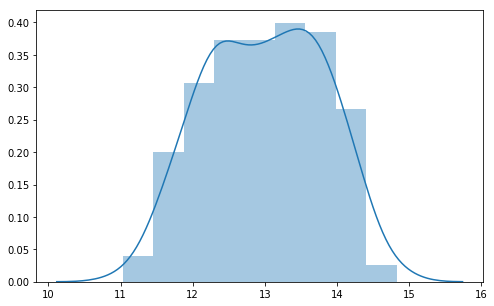

In [52]:
plt.figure(figsize=(8, 5))
sns.distplot(sample)
plt.show()

#### решение:

In [56]:
def pvalue_shapiro(sample):
    return sps.shapiro(sample)[1]

def pvalue_normtest(sample):
    return sps.normaltest(sample)[1]

def pvalue_skewtest(sample):
    return sps.skewtest(sample)[1]

def pvalue_liliefors(sample):
    return sps.kstest((sample - sample.mean()) / sample.std(), sps.norm.cdf)[0]

def pvalue_jarque_bera(sample):
    return sps.jarque_bera(sample)[1]

criteries = [pvalue_shapiro, pvalue_normtest, pvalue_skewtest, pvalue_liliefors, pvalue_jarque_bera]

def p_values_by_sample(sample):
    return np.array([test(sample) for test in criteries])

In [58]:
def holm(pvalues, alpha):
    m = pvalues.shape[0]
    stop = m
    for i, pval in enumerate(sorted(pvalues)):
        if pval >= alpha/(m - i):
            stop = i
            print('stop in {}'.format(i))
            break
    return np.argsort(pvalues)>=stop

In [61]:
holm(p_values_by_sample(sample), 0.05)

stop in 1


array([ True, False,  True,  True,  True])

Принимаем гипотезу о нормальности

Взял метод Холма, потому что:

* он контролирует FWER на уровне значимости $\alpha$

* не знаю характера зависимости между статистиками, поэтому нельзя построить процедуру, конотроллирующую FWER, мощнее Холма 

## Задача 4

#### exploratory data analysis

In [5]:
sample = np.load('./data/hw4t4.npy')

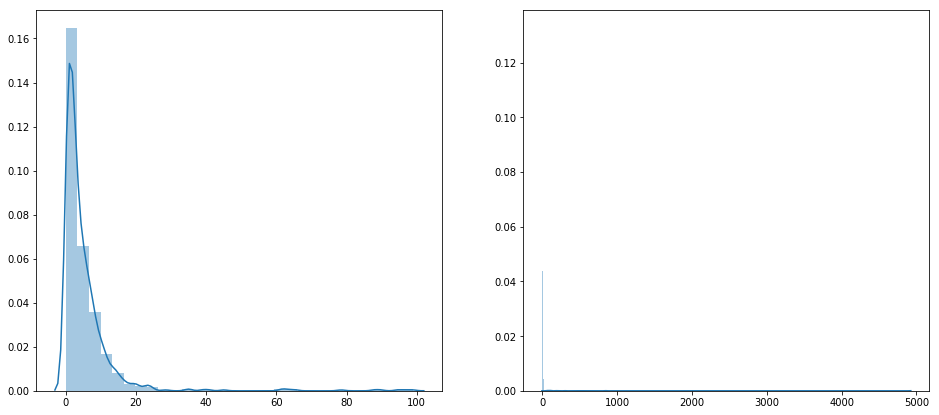

In [6]:
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
sns.distplot(sample[sample < 100], bins=30)
plt.subplot(1, 2, 2)
sns.distplot(sample, bins=1000)
plt.show()

In [7]:
print('stats:\nmin={:.2f}, max={:.2f}, mean={:.2f}, var={:.2f}'.format(np.min(sample), np.max(sample), 
                                                                       np.mean(sample), np.var(sample)))

stats:
min=0.00, max=4920.80, mean=23.09, var=61978.06


#### выбросы:

Очевидно, что распределение содержит выбросы. Найдем и выкинем их, используя метож Тьюки.

Для этого метода рассматриваем только правую границу, потому что левая и так будет отрицательной, значит все элементы выборки попадают в левую границу.

Правая граница (формула из лекции): $q_3 + k(q_3 - q_1)$

Где:
 * k = 1.5
 * $q_1$ и $q_3$ соответственно $0.25$ и $0.75$-квантили выборки

Выбросы -- те элементы данной выборки, которые не попали в интервал, заданый границами выше.

In [8]:
q_1, q_3 = np.percentile(sample, [25, 75])
k = 1.5

right_bbox = q_3 + k * (q_3 - q_1)

sample_tuki = sample[sample < right_bbox]

print("len all sample: {}\nlen sample after T'uki = {}".format(len(sample), len(sample_tuki)))

len all sample: 1000
len sample after T'uki = 937


#### выбор распределения и проверка гипотез

In [9]:
loc, scale = sps.expon.fit(sample_tuki)
sps.kstest(sample_tuki, 'expon', args=[loc, scale])

KstestResult(statistic=0.03847573715767705, pvalue=0.12160180821548972)

Достаточно хорошое p-value, которое дает нам право полагать, что данная выборка из экспоненциального распределения

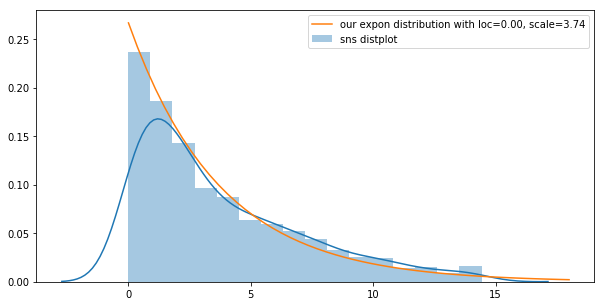

In [10]:
plt.figure(figsize=(10, 5))
x = np.linspace(1e-2, 18)
sns.distplot(sample_tuki, label='sns distplot')
expon = sps.expon(loc, scale).pdf(x)
plt.ylim(0, 0.28)
plt.plot(x, expon, label='our expon distribution with loc={:.2f}, scale={:.2f}'.format(loc, scale))
plt.legend()
plt.show()

#### Среднее время лампочки:

Очевидно, выбросы очень сильно искажают среднее время жизни лампочки, поэтому считаем без них:

In [11]:
'среднее время жизни лампочки = {:.2f} дней'.format(sample_tuki.mean())

'среднее время жизни лампочки = 3.74 дней'

## Задача 5

#### создание выборок:

In [22]:
ls data/

GPS Trajectory/     data2.3.npy         slump_test.data     vowel.data
GPS Trajectory.rar  hw4t4.npy           vowel-context.data  wine.data


In [29]:
wine = pd.read_csv('./data/wine.data', header=None)
vowel = pd.read_csv('./data/vowel-context.data', header=None, sep=' ')
slump = pd.read_csv('./data/slump_test.data')

In [30]:
wine[:2]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050


In [31]:
vowel[:2]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,NaN,0.0
1,0,0,0,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,NaN,1.0


In [32]:
slump[:2]

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14


In [33]:
samples = [
    slump['Compressive Strength (28-day)(Mpa)'],
    wine[4],
    vowel[7],
    wine[1], 
    wine[3],
    wine[8],
    wine[9]
]

#### решение:

In [41]:
def pvalue_shapiro(sample):
    return sps.shapiro(sample)[1]

def pvalue_normtest(sample):
    return sps.normaltest(sample)[1]

def pvalue_skewtest(sample):
    return sps.skewtest(sample)[1]

def pvalue_liliefors(sample):
    return sps.kstest((sample - sample.mean()) / sample.std(), sps.norm.cdf)[0]

def pvalue_jarque_bera(sample):
    return sps.jarque_bera(sample)[1]

criteries = [pvalue_shapiro, pvalue_normtest, pvalue_skewtest, pvalue_liliefors, pvalue_jarque_bera]

def p_values_by_sample(sample):
    return [test(sample) for test in criteries]

In [42]:
for i in range(len(samples)):
    print(multipletests(pvals=p_values_by_sample(samples[i]), alpha=0.05, method='fdr_by')[0])

[False False False False False]
[False False False False False]
[False False False False False]
[False  True False False False]
[False False False False False]
[ True  True  True False  True]
[ True  True  True False  True]


In [43]:
for i in range(len(samples)):
    print(multipletests(pvals=p_values_by_sample(samples[i]), alpha=0.05, method='fdr_bh')[0])

[False False False False False]
[False False False False False]
[False False False False False]
[False  True False False False]
[False False False False  True]
[ True  True  True False  True]
[ True  True  True False  True]


Одно из условий применимости, независимость статистик, не выполнено: мы вычисляем p_values от одной и той же статистики

Однако, если мы отвергаем всю серию из-за одной гипотезы, то в данном случае результаты совпадают.

Итого, распределены нормально:

* "Compressive Strength (28-day)(Mpa)" из slump_test

* "Alcalinity of ash" из wine

* vowel[7]

* "Ash" из wine 